In [44]:
# Import necesary libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [5]:
# Load dataset
df = pd.read_parquet("data/yellow_tripdata_2025-01.parquet")
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


In [6]:
# How big is the dataset?
print("Shape:", df.shape)

Shape: (3475226, 20)


In [7]:
# What are the columns and data types?
print("\nColumn types:")
print(df.dtypes)


Column types:
VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag                  str
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
cbd_congestion_fee              float64
dtype: object


In [8]:
# Are there any missing values?
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          540149
trip_distance                 0
RatecodeID               540149
store_and_fwd_flag       540149
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     540149
Airport_fee              540149
cbd_congestion_fee            0
dtype: int64


In [9]:
# Basic stats on numeric columns
print("\nBasic stats:")
print(df.describe())


Basic stats:
           VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  3.475226e+06                     3475226                     3475226   
mean   1.785428e+00  2025-01-17 11:02:55.910964  2025-01-17 11:17:56.997901   
min    1.000000e+00         2024-12-31 20:47:55         2024-12-18 07:52:40   
25%    2.000000e+00         2025-01-10 07:59:01  2025-01-10 08:15:29.500000   
50%    2.000000e+00         2025-01-17 15:41:33         2025-01-17 15:59:34   
75%    2.000000e+00         2025-01-24 19:34:06         2025-01-24 19:48:31   
max    7.000000e+00         2025-02-01 00:00:44         2025-02-01 23:44:11   
std    4.263282e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     2.935077e+06   3.475226e+06  2.935077e+06  3.475226e+06   
mean      1.297859e+00   5.855126e+00  2.482535e+00  1.651916e+02   
min       0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00  

In [25]:
# Extract function
def extract():
    df = pd.read_parquet("data/yellow_tripdata_2025-01.parquet")
    print(f"Rows before cleaning: {len(df):,}")
    return df

In [26]:
# Transform function
def transform(df):
    # Drop rows with 0 or null passengers
    df = df[df["passenger_count"] > 0]
    df = df.dropna(subset=["passenger_count", "RatecodeID", "congestion_surcharge"])

    # Drop unrealistic trip distances
    df = df[df["trip_distance"] > 0]
    df = df[df["trip_distance"] <= 100]

    # Drop negative fares
    df = df[df["fare_amount"] >= 0]

    # Keep only January 2025 trips
    df = df[df["tpep_pickup_datetime"] >= "2025-01-01"]
    df = df[df["tpep_pickup_datetime"] < "2025-02-01"]

    # Add a derived column: trip duration in minutes
    df["trip_duration_minutes"] = (
        df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    ).dt.total_seconds() / 60

    # Drop unrealistic durations (negative or over 3 hours)
    df = df[df["trip_duration_minutes"] > 0]
    df = df[df["trip_duration_minutes"] <= 180]

    print(f"Rows after cleaning: {len(df):,}")
    return df
    

In [28]:
# load function
def load(df):
    df.to_parquet("data/yellow_tripdata_cleaned.parquet", index=False)
    print("Cleaned data saved to yellow_tripdata_cleaned.parquet")

In [29]:
# Run fuction
def run():
    try:
        raw = extract()
        cleaned = transform(df)
        load(cleaned)
    except Exception as e:
        print(f"Pipeline failed: {e}")

In [30]:
run()

Rows before cleaning: 3,475,226
Rows after cleaning: 2,814,992
Cleaned data saved to yellow_tripdata_cleaned.parquet


In [45]:
df = pd.read_parquet("data/yellow_tripdata_cleaned.parquet")
print(f"Rows loaded: {len(df):,}")
df.head()

Rows loaded: 2,814,992


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,trip_duration_minutes
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,...,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0,8.350000
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,...,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0,2.550000
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,...,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0,1.950000
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,...,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0,5.566667
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,...,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0,3.533333


In [35]:
conn = sqlite3.connect("nyc_taxi.db")

df.to_sql("trips", conn, if_exists="replace", index=False)

print("Data loaded into nyc_taxi.db")

Data loaded into nyc_taxi.db


In [36]:
result = pd.read_sql("SELECT COUNT(*) as total_trips FROM trips", conn)
result

,total_trips
0,2814992


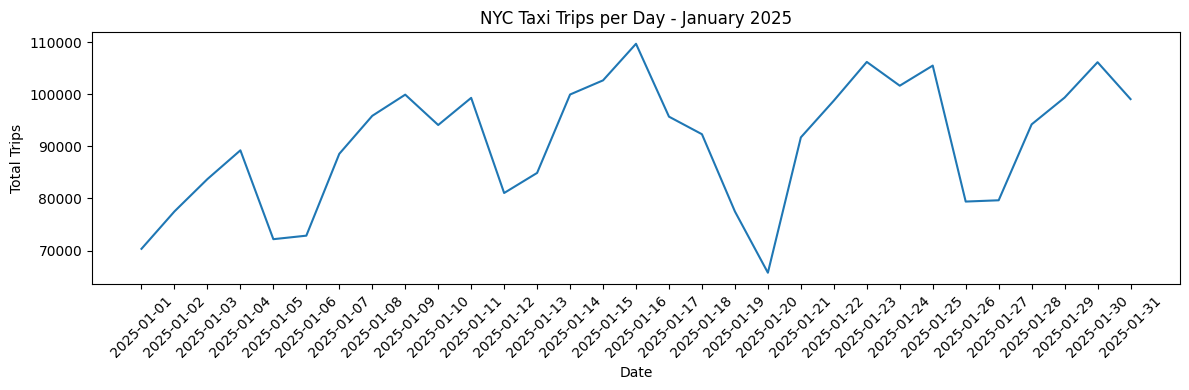

In [53]:
# How many trips per day?
df_trips_daily = pd.read_sql("""
    SELECT 
        DATE(tpep_pickup_datetime) as trip_date,
        COUNT(*) as total_trips
    FROM trips
    GROUP BY trip_date
    ORDER BY trip_date
""", conn)

plt.figure(figsize=(12,4))
plt.plot(df_trips_daily["trip_date"], df_trips_daily["total_trips"])
plt.title("NYC Taxi Trips per Day - January 2025")
plt.xlabel("Date")
plt.ylabel("Total Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

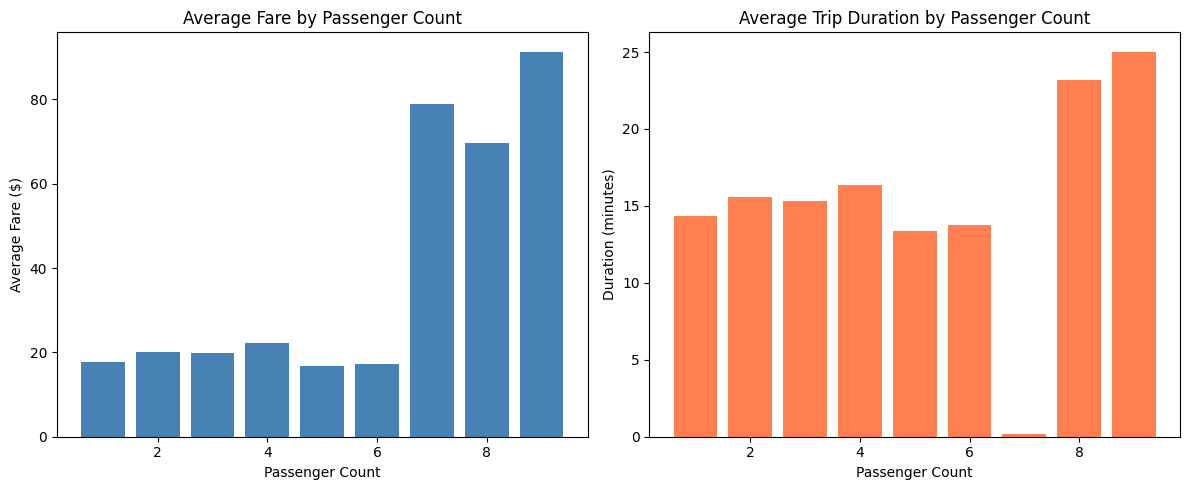

In [54]:
# Average fare and trip duration by passenger count
df_pax = pd.read_sql("""
    SELECT 
        passenger_count,
        COUNT(*) as total_trips,
        ROUND(AVG(fare_amount), 2) as avg_fare,
        ROUND(AVG(trip_duration_minutes), 2) as avg_duration_minutes
    FROM trips
    GROUP BY passenger_count
    ORDER BY passenger_count
""", conn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(df_pax["passenger_count"], df_pax["avg_fare"], color="steelblue")
ax1.set_title("Average Fare by Passenger Count")
ax1.set_xlabel("Passenger Count")
ax1.set_ylabel("Average Fare ($)")

ax2.bar(df_pax["passenger_count"], df_pax["avg_duration_minutes"], color="coral")
ax2.set_title("Average Trip Duration by Passenger Count")
ax2.set_xlabel("Passenger Count")
ax2.set_ylabel("Duration (minutes)")

plt.tight_layout()
plt.show()

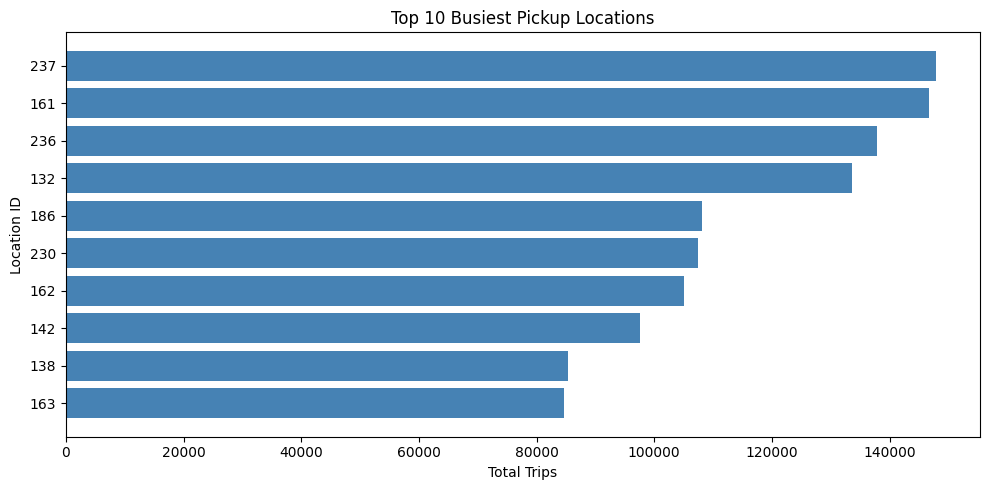

In [56]:
# Busiest pickup locations
df_locations = pd.read_sql("""
    SELECT
        PULocationID,
        COUNT(*) as total_trips
    FROM trips
    GROUP BY PULocationID
    ORDER BY total_trips DESC
    LIMIT 10
""", conn)

plt.figure(figsize=(10, 5))
plt.barh(df_locations["PULocationID"].astype(str), df_locations["total_trips"], color="steelblue")
plt.title("Top 10 Busiest Pickup Locations")
plt.xlabel("Total Trips")
plt.ylabel("Location ID")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

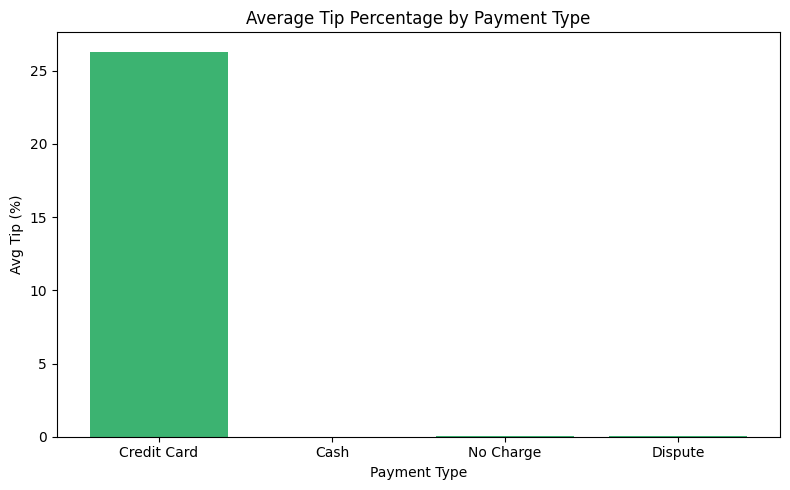

In [57]:
# Average tip percentage by payment type 
df_tips = pd.read_sql("""
    SELECT 
        payment_type,
        COUNT(*) as total_trips,
        ROUND(AVG(tip_amount / NULLIF(fare_amount, 0) * 100), 2) as avg_tip_pct
    FROM trips
    GROUP BY payment_type
    ORDER BY payment_type
""", conn)

payment_labels = {1: "Credit Card", 2: "Cash", 3: "No Charge", 4: "Dispute"}
df_tips["label"] = df_tips["payment_type"].map(payment_labels)

plt.figure(figsize=(8, 5))
plt.bar(df_tips["label"], df_tips["avg_tip_pct"], color="mediumseagreen")
plt.title("Average Tip Percentage by Payment Type")
plt.xlabel("Payment Type")
plt.ylabel("Avg Tip (%)")
plt.tight_layout()
plt.show()

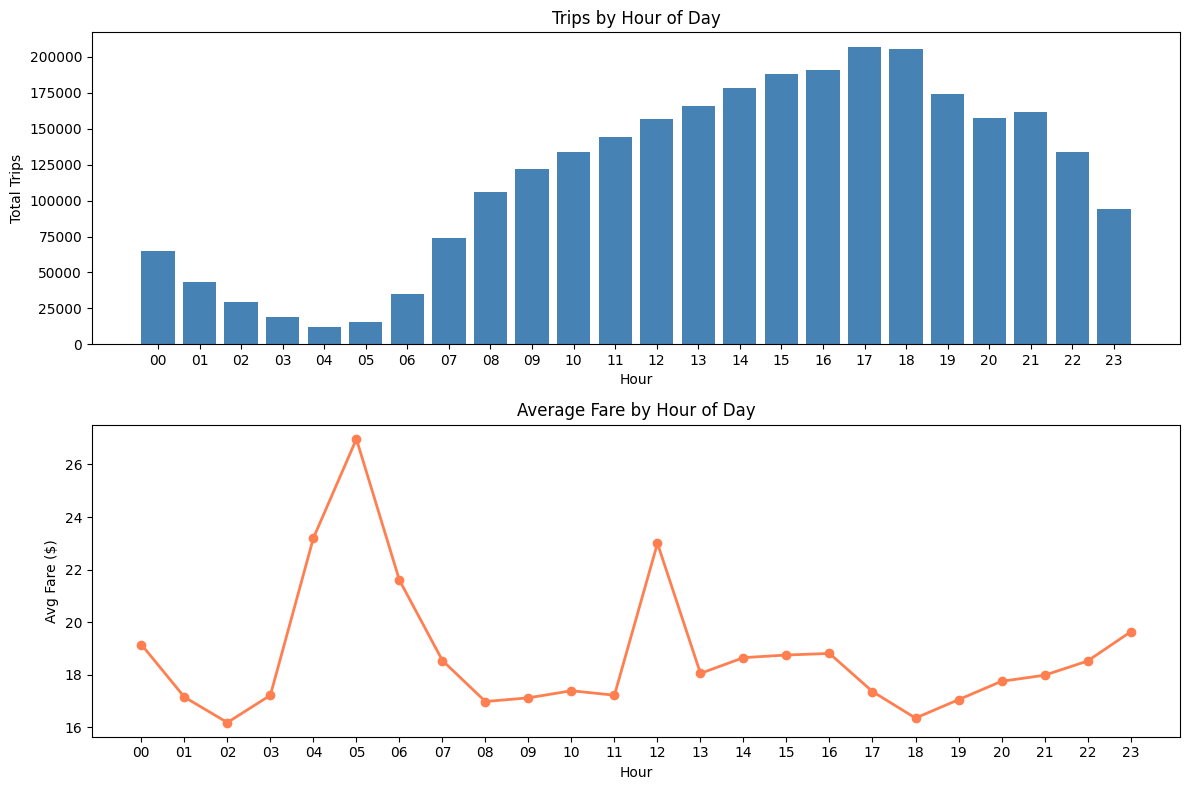

In [58]:
# Peak hours for taxi trips
df_hours = pd.read_sql("""
    SELECT 
        STRFTIME('%H', tpep_pickup_datetime) as hour_of_day,
        COUNT(*) as total_trips,
        ROUND(AVG(fare_amount), 2) as avg_fare
    FROM trips
    GROUP BY hour_of_day
    ORDER BY hour_of_day
""", conn)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.bar(df_hours["hour_of_day"], df_hours["total_trips"], color="steelblue")
ax1.set_title("Trips by Hour of Day")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Total Trips")

ax2.plot(df_hours["hour_of_day"], df_hours["avg_fare"], marker="o", color="coral", linewidth=2)
ax2.set_title("Average Fare by Hour of Day")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Avg Fare ($)")

plt.tight_layout()
plt.show()
